In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/air-passengers/AirPassengers.csv


Importing and displaying the first five rows of the dataset.

In [2]:
df = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


* Seasonality - Repeating trends
* Cyclical - Trends with no repetition. There is no repetitive cycle.
* 

In [3]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


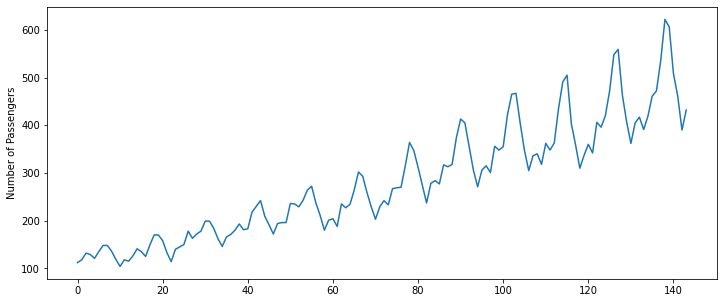

In [4]:
ax = df['#Passengers'].plot(figsize = (12,5))
ax.set(ylabel='Number of Passengers');

In [5]:
df.rename(columns = {'#Passengers' : 'Passengers'}, 
          inplace = True)
df['Month'] = pd.to_datetime(df['Month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


The **Hodrick-Prescott Filter** Separates a Time Series into Trend and Cyclical Components.
Link: https://www.statsmodels.org/stable/generated/statsmodels.tsa.filters.hp_filter.hpfilter.html#generated-statsmodels-tsa-filters-hp-filter-hpfilter--page-root

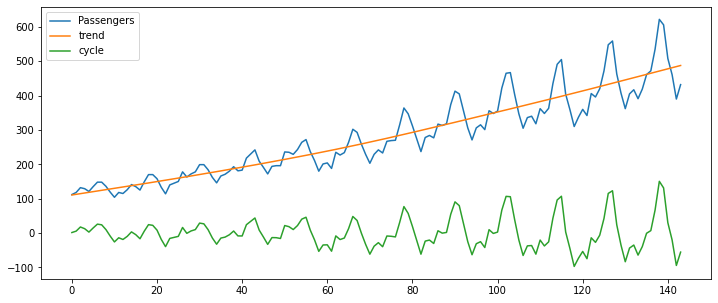

In [6]:
cycle, trend = sm.tsa.filters.hpfilter(df.Passengers, 129600)
decomp = df[['Passengers']]
decomp["cycle"] = cycle
decomp["trend"] = trend

fig, ax = plt.subplots()
decomp[["Passengers", "trend", "cycle"]].plot(ax=ax, figsize=(12, 5))
plt.show()

**Time Series Decomposition with Error Trend Seasonality Model**
* Trend Component shows the general growth/decline pattern.
* Seasonal Component shows any repetitive cycles in the time series. 
* Residual Component is the error or noise that cannot be represented as Trend or Seaonality.

**Additive Model** is used when the trend is more linear and the Trend and Seasonality Components are increasing/decreasing at a constant rate over time. 
**Multiplicative Model** is used when the Trend and Seasonality Components are increasing/decreasing at a non-linear rate over time.

In [7]:
df.dropna(inplace=True)
df.set_index('Month', inplace = True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


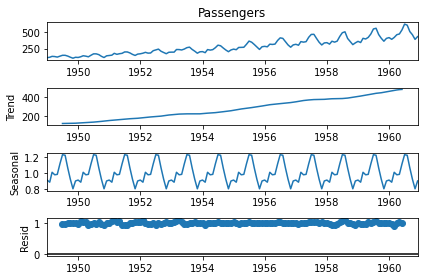

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df.Passengers, model='multiplicative')
results.plot();

Exponentially Weighted Moving Average Models - EWMA Models
* More recent data has more weightage.

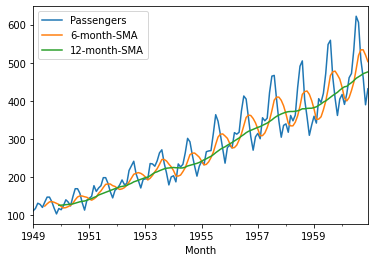

In [9]:
# Simple Moving Average
df_sma = df.copy()
df_sma['6-month-SMA'] = df['Passengers'].rolling(window=6).mean()
df_sma['12-month-SMA'] = df['Passengers'].rolling(window=12).mean()
df_sma.plot();

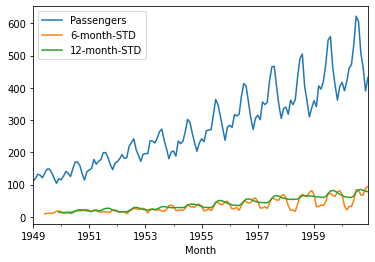

In [12]:
# Standard Deviation
df_sma_2 = df.copy()
df_sma_2['6-month-STD'] = df['Passengers'].rolling(window=6).std()
df_sma_2['12-month-STD'] = df['Passengers'].rolling(window=12).std()
df_sma_2.plot();

In [ ]:
df_ewma = df.copy()
df_ewma['EWMA12'] = df['Passengers'].ewm(span=12,
                                         adjust=False).mean()
df_ewma.plot();

Holt-winters seasonal method comprises of the forecast equation and three smoothing equations. level, trend, and seasonal components.
Single Exponential Smoothing.
Double Exponential Smoothing (Holts-method)


In [ ]:
df.index.freq = 'MS'
df.index

In [ ]:
df.head()

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
span = 12
alpha = 2/(span + 1)

In [ ]:
df['EWMA12'] = df['Passengers'].ewm(alpha=alpha,
                                   adjust=False).mean()
df.head()

In [ ]:
model = SimpleExpSmoothing(df['Passengers'])
fitted_model = model.fit(smoothing_level = alpha,
                         optimized = False)
df['SES12'] = fitted_model.fittedvalues.shift(-1)
df.head()

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
model = ExponentialSmoothing(df['Passengers'], trend = 'add')
fitted_model = model.fit()
df['DES_add_12'] = fitted_model.fittedvalues.shift(-1)
df.head()

In [ ]:
df.plot(figsize = (12,5))

Forecasting Procedure:
* Choose a Model
* Split data into train and test sets
* Fit model on training set
* Evaluate model on test set
* Re-fit model on entire dataset
* Forecast for future data



The Test Set should ideally be at least as large as the maximum forecast horizon required, i.e the maximum lenght of the future forecast. Keep in mind the longer the forecast horizon, the more likely your prediction becomes less accurate.

In [ ]:
df = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv',
                index_col = 'Month', parse_dates = True)
df.index.freq = 'MS'
df.rename(columns = {'#Passengers' : 'Passengers'}, 
          inplace = True)
df.head()

In [ ]:
df.info()

In [ ]:
train_date = df.iloc[:109] # df.loc[:'1940-01-01']
test_data = df.iloc[108:]

In [ ]:
fitted_model = ExponentialSmoothing(train_date['Passengers'],
                                   trend = 'mul',
                                   seasonal = 'mul',
                                   seasonal_periods = 12).fit()

In [ ]:
test_predictions = fitted_model.forecast(36) # 8 years

In [ ]:
train_date['Passengers'].plot(legend=True, label = 'Train',
                             figsize = (12,5))
test_data['Passengers'].plot(legend=True, label = 'Test')
test_predictions.plot(legend=True, label = 'Prediction')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
print('MSE: ', mean_squared_error(test_data, test_predictions))
print('MAE', mean_absolute_error(test_data, test_predictions))
print('RMSE: ', np.sqrt(mean_squared_error(test_data, test_predictions)))

Stationary data does not exhibit trend or seasonality.

In [ ]:
from statsmodels.tsa.statespace.tools import diff

In [ ]:
# First Order Difference
df['Passengers'] - df['Passengers'].shift(1)

In [ ]:
diff(df['Passengers'], k_diff = 1).plot() 

An autocorrelation plot (also known as a Correlogram) shows the correlation of the series with itself, lagged by x time units.
The y-axis is the correlation and the x-axis is the number of units of lag.
For example, if we compare the standard sales data against the sales data shifted by 1 time step (one day) then we are answering the question, "how correlated are today's sales to yesterday's sales?"
ACF describes the autocorrelation between an observation and another observation at a prior time step that included direct and indirect dependence information.
The PACF only describes the direct relationship between an observation and its lag.

In [ ]:
test_predictions_8years = fitted_model.forecast(96) # 8 years

In [ ]:
train_date['Passengers'].plot(legend=True, label = 'Train',
                             figsize = (12,5))
test_data['Passengers'].plot(legend=True, label = 'Test')
test_predictions_8years.plot(legend=True, label = 'Prediction')